In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

In [2]:
# On sélectionne le top20 des capitalisations boursières du CAC 40 en janvier 2010

titres = [
    "TTE.PA",      # TotalEnergies
    "BN.PA",       # Danone
    "SAN.PA",      # Sanofi
    "BNP.PA",      # BNP Paribas
    "ENGI.PA",     # Engie
    "ORA.PA",      # Orange
    "MC.PA",       # LVMH Moet Hennessy
    "CS.PA",       # AXA
    "OR.PA",       # L'Oréal
    "GLE.PA",      # Société Générale
    "AI.PA",       # Air Liquide
    "AIR.PA",      # Airbus
    "ALO.PA",      # Alstom
    "MT.AS",       # ArcelorMittal
    "KER.PA",      # Kering
    "SGO.PA",      # Saint-Gobain
    "SU.PA",       # Schneider Electric
    "STM",         # STMicroelectronics
    "UL.PA",       # Unibail-Rodamco
    "VIE.PA"       # Veolia Environnement
]

data = yf.download(titres, start="2010-01-01", end="2024-01-01", interval="1d") #période et fréquence des données
portfolio_returns = data['Adj Close'].pct_change().mean(axis=1) #portfolio return

[*********************100%%**********************]  20 of 20 completed


In [3]:
# benchmark (CAC 40)

benchmark = yf.download("^FCHI", start="2010-01-01", end="2024-01-01", interval="1d")
benchmark_returns = benchmark['Adj Close'].pct_change() #benchmark return

[*********************100%%**********************]  1 of 1 completed


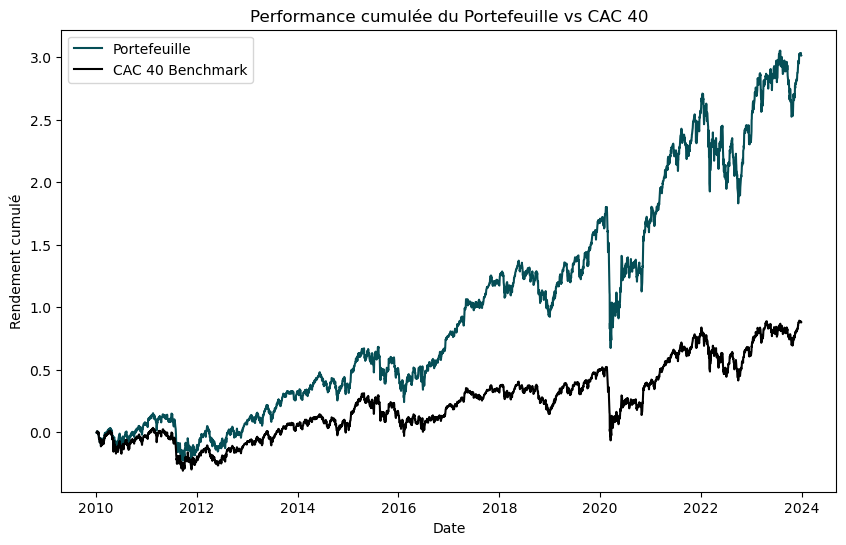

Performance du Portefeuille sur la période : 301.12%
Performance du Benchmark (CAC 40) sur la période : 87.92%


In [4]:
# Calcul des rendements cumulés
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1
cumulative_benchmark_returns = (1 + benchmark_returns).cumprod() - 1

# Tracé des performances cumulées
plt.figure(figsize=(10,6))
plt.plot(cumulative_portfolio_returns, label='Portefeuille', color = '#054E56')
plt.plot(cumulative_benchmark_returns, label='CAC 40 Benchmark', linestyle='-', color = 'black')
plt.title('Performance cumulée du Portefeuille vs CAC 40')
plt.xlabel('Date')
plt.ylabel('Rendement cumulé')
plt.legend()
plt.show()

# Performance finale du portefeuille et du benchmark en pourcentage
portfolio_performance_percent = cumulative_portfolio_returns.iloc[-1] * 100
benchmark_performance_percent = cumulative_benchmark_returns.iloc[-1] * 100

print(f"Performance du Portefeuille sur la période : {portfolio_performance_percent:.2f}%")
print(f"Performance du Benchmark (CAC 40) sur la période : {benchmark_performance_percent:.2f}%")

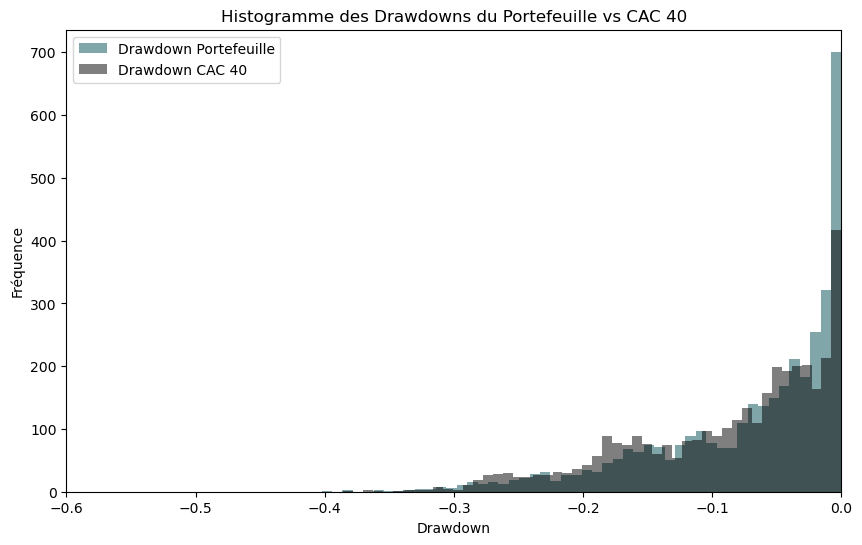

In [5]:
# Fonction pour calculer le drawdown
def calculate_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    previous_peaks = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - previous_peaks) / previous_peaks
    return drawdowns

# Calcul des drawdowns pour le portefeuille et le benchmark
portfolio_drawdown = calculate_drawdown(portfolio_returns)
benchmark_drawdown = calculate_drawdown(benchmark_returns)

# Tracé des drawdowns avec des limites pour l'axe vertical
# Tracé des drawdowns sous forme d'histogramme
plt.figure(figsize=(10,6))

# Histogramme pour le portefeuille
plt.hist(portfolio_drawdown.dropna(), bins=50, alpha=0.5, label='Drawdown Portefeuille', color ="#054E56")

# Histogramme pour le benchmark
plt.hist(benchmark_drawdown.dropna(), bins=50, alpha=0.5, label='Drawdown CAC 40', linestyle='--', color ="black")

plt.title('Histogramme des Drawdowns du Portefeuille vs CAC 40')
plt.xlabel('Drawdown')
plt.ylabel('Fréquence')
plt.xlim(-0.60, 0)  # Limites pour l'axe horizontal
plt.legend()
plt.show()

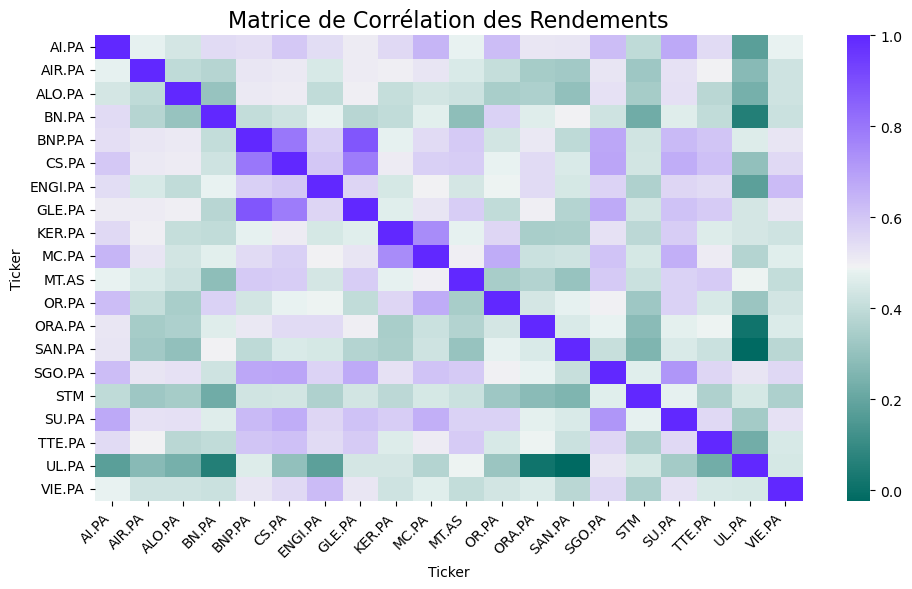

In [6]:
# Matrice de corrélation des rendements ajustés des actions du portefeuille
adj_close_data = data['Adj Close']  # Suppose que tu as déjà téléchargé les données d'ajustement des cours
returns = adj_close_data.pct_change()

# Calcul de la matrice de corrélation
corr_matrix = returns.corr()

# Création d'un graphique heatmap avec seaborn
custom_cmap = sns.diverging_palette(180, 270, s=100, l=40, n=100, as_cmap=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap=custom_cmap, annot=False, cbar=True)
plt.title('Matrice de Corrélation des Rendements', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Secteur
Consommation                  10
Finance                       10
Immobilier                     5
Industrie                     20
Luxe                          10
Matériaux                      5
Santé                          5
Services aux collectivités     5
Technologie                   10
Télécommunications             5
Énergie                       15
Name: Poids (%), dtype: int64


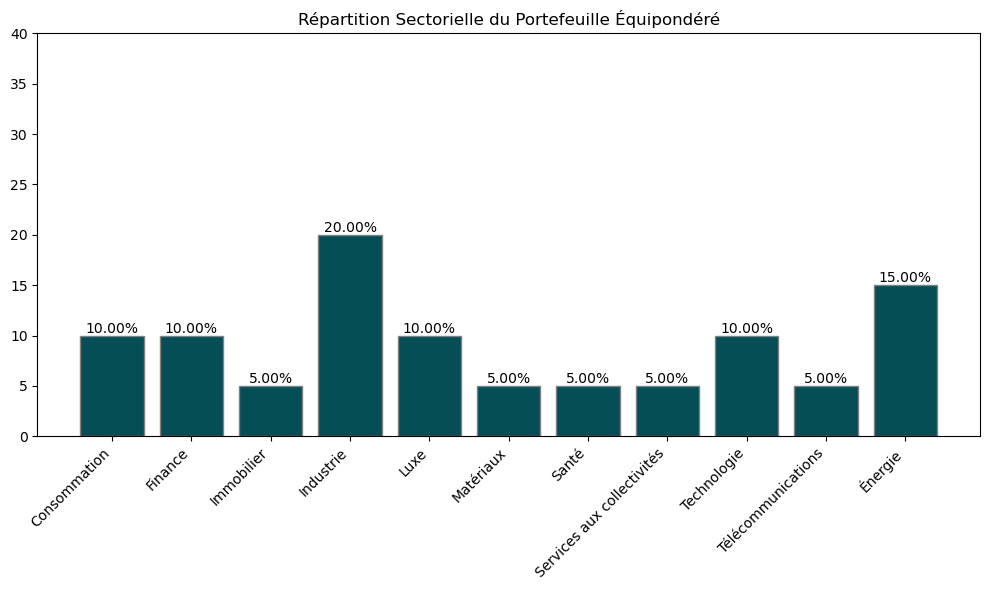

In [7]:
# Dictionnaire des secteurs pour les tickers donnés
sectors = {
    'TTE.PA': 'Énergie',
    'BN.PA': 'Consommation',
    'SAN.PA': 'Santé',
    'BNP.PA': 'Finance',
    'ENGI.PA': 'Énergie',
    'ORA.PA': 'Télécommunications',
    'MC.PA': 'Luxe',
    'CS.PA': 'Technologie',
    'OR.PA': 'Consommation',
    'GLE.PA': 'Finance',
    'AI.PA': 'Industrie',
    'AIR.PA': 'Industrie',
    'ALO.PA': 'Industrie',
    'MT.AS': 'Industrie',
    'KER.PA': 'Luxe',
    'SGO.PA': 'Matériaux',
    'SU.PA': 'Énergie',
    'STM': 'Technologie',
    'UL.PA': 'Immobilier',
    'VIE.PA': 'Services aux collectivités'
}

# DataFrame avec une répartition équipondérée (chaque actif = 5%)
summary_df = pd.DataFrame({
    'Ticker': titres,
    'Poids (%)': [5] * len(titres)  # Chaque actif a un poids de 5%
})

# Mapping des secteurs sur les tickers
summary_df['Secteur'] = summary_df['Ticker'].map(sectors)

# Calcul de la répartition sectorielle en pourcentage
sector_exposure = summary_df.groupby('Secteur')['Poids (%)'].sum()

# Affichage de la répartition sectorielle
print(sector_exposure)

# Visualisation de la répartition sectorielle (histogramme)
plt.figure(figsize=(10, 6))
bars = plt.bar(sector_exposure.index, sector_exposure, color='#054E56', edgecolor='grey')
plt.title('Répartition Sectorielle du Portefeuille Équipondéré', fontsize=12, color='black')
plt.xlabel('', fontsize=12, color='black')
plt.ylabel('', fontsize=12, color='black')
plt.ylim(0, 40)  # Ajuste selon les proportions réelles
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')
plt.grid(False)

# Afficher les pourcentages au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


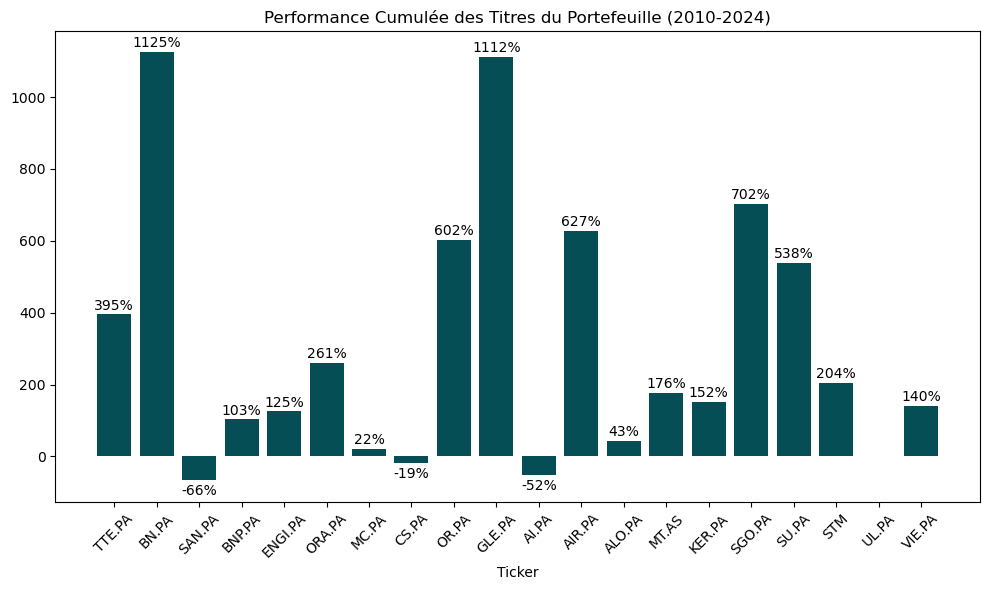

In [8]:
# Calcul du rendement cumulé de 2010 à 2024
cumulative_returns = (data['Adj Close'].iloc[-1] / data['Adj Close'].iloc[0] - 1) * 100  # Rendement en %

# Exemple de DataFrame pour stocker les résultats
summary_df = pd.DataFrame({
    'Ticker': titres,
    'Performance Cumulée (%)': cumulative_returns.values
})

# Affichage du diagramme en barres pour la performance cumulée
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_df['Ticker'], summary_df['Performance Cumulée (%)'], color='#054E56')
plt.title('Performance Cumulée des Titres du Portefeuille (2010-2024)')
plt.xlabel('Ticker')
plt.ylabel('')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    # Si la valeur est négative, place l'étiquette en dessous de la barre
    if height < 0:
        plt.text(bar.get_x() + bar.get_width() / 2.0, height - 50, f'{height:.0f}%', ha='center', va='bottom', fontsize=10)
    else:
        # Sinon, place l'étiquette au-dessus de la barre
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 5, f'{height:.0f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

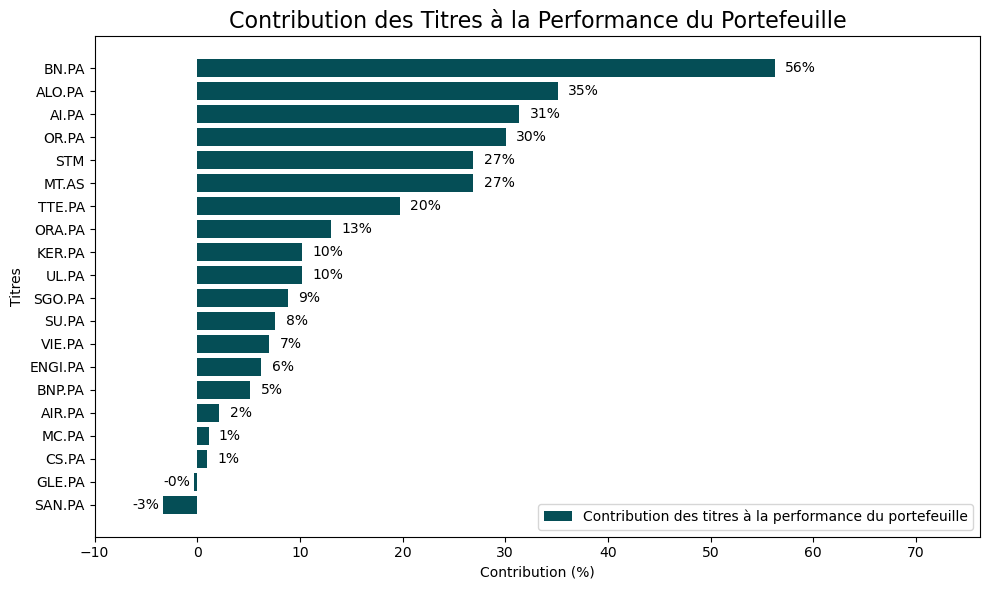

In [9]:
data = {
    'Ticker': ['TTE.PA', 'BN.PA', 'SAN.PA', 'BNP.PA', 'ENGI.PA', 'ORA.PA', 
               'MC.PA', 'CS.PA', 'OR.PA', 'GLE.PA', 'AI.PA', 'AIR.PA', 
               'ALO.PA', 'MT.AS', 'KER.PA', 'SGO.PA', 'SU.PA', 'STM', 
               'UL.PA', 'VIE.PA'],
    'Poids (%)': [5] * 20,  # Poids équipondéré (5% chaque titre)
    'Performance Cumulée (%)': [395.24, 1124.82, -66.34, 103.19, 125.04, 
                                260.58, 21.99, 18.71, 601.63, -5.53, 
                                627.27, 43.10, 702.32, 537.72, 204.30, 
                                175.73, 152.18, 537.72, 204.30, 140.42]
}

summary_df = pd.DataFrame(data)

# Calcul de la contribution de chaque titre à la performance du portefeuille
summary_df['Contribution'] = (summary_df['Poids (%)'] / 100) * summary_df['Performance Cumulée (%)']

# Tri par contribution croissante
summary_df_sorted = summary_df.sort_values('Contribution', ascending=True)

# Visualisation de la contribution des titres
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(summary_df_sorted['Ticker'], summary_df_sorted['Contribution'], color='#054E56', label="Contribution des titres à la performance du portefeuille")

# Ajouter des étiquettes avec la contribution au bout de chaque barre
for bar in bars:
    width = bar.get_width()
    rounded_width = round(width, 2)  # Arrondir la valeur de la largeur

    # Ajustement pour les valeurs négatives
    if rounded_width < 0:
        ax.text(rounded_width - 3, bar.get_y() + bar.get_height()/2, f'{rounded_width:.0f}%', va='center', fontsize=10, color='black')
    # Ne pas afficher l'étiquette pour les valeurs très proches de zéro
    elif -0.01 <= rounded_width <= 0.01:
        continue  
    # Cas normal pour les valeurs positives
    else:
        ax.text(rounded_width + 1, bar.get_y() + bar.get_height()/2, f'{rounded_width:.0f}%', va='center', fontsize=10, color='black')

# Limiter l'axe des abscisses (x) pour ajuster la vue
ax.set_xlim(-10, summary_df['Contribution'].max() + 20)

# Titres et labels
ax.set_title('Contribution des Titres à la Performance du Portefeuille', fontsize=16)
ax.set_xlabel('Contribution (%)')
ax.set_ylabel('Titres')
ax.legend(loc='lower right')

# Suppression de la grille
ax.grid(False)

plt.tight_layout()
plt.show()

In [10]:
# Calcul de la contribution de chaque titre à la performance du portefeuille
summary_df['Contribution'] = (summary_df['Poids (%)'] / 100) * summary_df['Performance Cumulée (%)']

# Calcul de la somme totale des contributions
total_contribution = summary_df['Contribution'].sum()

# Affichage des contributions individuelles et de la somme totale
print(summary_df[['Ticker', 'Contribution']])
print(f"\nLa somme des contributions est : {total_contribution:.6f}")

     Ticker  Contribution
0    TTE.PA       19.7620
1     BN.PA       56.2410
2    SAN.PA       -3.3170
3    BNP.PA        5.1595
4   ENGI.PA        6.2520
5    ORA.PA       13.0290
6     MC.PA        1.0995
7     CS.PA        0.9355
8     OR.PA       30.0815
9    GLE.PA       -0.2765
10    AI.PA       31.3635
11   AIR.PA        2.1550
12   ALO.PA       35.1160
13    MT.AS       26.8860
14   KER.PA       10.2150
15   SGO.PA        8.7865
16    SU.PA        7.6090
17      STM       26.8860
18    UL.PA       10.2150
19   VIE.PA        7.0210

La somme des contributions est : 295.219500


# Composition de notre portefeuille

Notre portefeuille est composé des titres suivants :

| Ticker     | Entreprise         | Poids dans le portefeuille | Contribution (%) |
|------------|--------------------|----------------------------|------------------|
| **TTE.PA** | TotalEnergies       | 5%                         | 19.76%           |
| **BN.PA**  | Danone             | 5%                         | 56.24%           |
| **SAN.PA** | Sanofi             | 5%                         | -3.32%           |
| **BNP.PA** | BNP Paribas        | 5%                         | 5.16%            |
| **ENGI.PA**| Engie              | 5%                         | 6.25%            |
| **ORA.PA** | Orange             | 5%                         | 13.03%           |
| **MC.PA**  | LVMH               | 5%                         | 1.10%            |
| **CS.PA**  | AXA                | 5%                         | 0.94%            |
| **OR.PA**  | L'Oréal            | 5%                         | 30.08%           |
| **GLE.PA** | Société Générale   | 5%                         | -0.28%           |
| **AI.PA**  | Air Liquide        | 5%                         | 31.36%           |
| **AIR.PA** | Airbus             | 5%                         | 2.16%            |
| **ALO.PA** | Alstom             | 5%                         | 35.12%           |
| **MT.AS**  | ArcelorMittal      | 5%                         | 26.89%           |
| **KER.PA** | Kering             | 5%                         | 10.22%           |
| **SGO.PA** | Saint-Gobain       | 5%                         | 8.79%            |
| **SU.PA**  | Schneider Electric | 5%                         | 7.61%            |
| **STM**    | STMicroelectronics | 5%                         | 26.89%           |
| **UL.PA**  | Unibail-Rodamco    | 5%                         | 10.22%           |
| **VIE.PA** | Veolia Environnement| 5%                         | 7.02%            |


In [12]:
# Liste des tickers de ton portefeuille
tickers = ['TTE.PA', 'BN.PA', 'SAN.PA', 'BNP.PA', 'ENGI.PA', 'ORA.PA', 
           'MC.PA', 'CS.PA', 'OR.PA', 'GLE.PA', 'AI.PA', 'AIR.PA', 
           'ALO.PA', 'MT.AS', 'KER.PA', 'SGO.PA', 'SU.PA', 'STM', 
            'VIE.PA']

# Poids équipondéré de chaque titre (5%)
weights = np.array([5/100] * len(tickers))

# Taux sans risque (par exemple, à 0.5%)
risk_free_rate = 0.005 / 252

[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


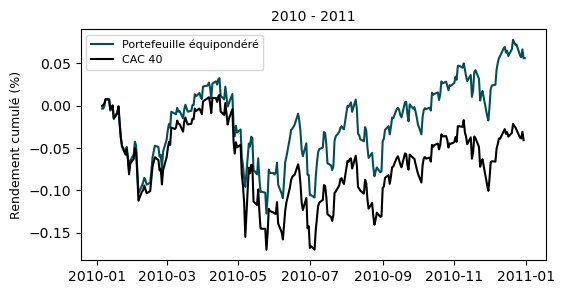

[********              16%%                      ]  3 of 19 completed

Performance du Portefeuille de 2010 à 2011 : 5.60%
Performance du Benchmark (CAC 40) de 2010 à 2011 : -4.07%

Sharpe Ratio du Portefeuille de 2010 à 2011 : 0.33
Sharpe Ratio du Benchmark (CAC 40) de 2010 à 2011 : -0.08



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


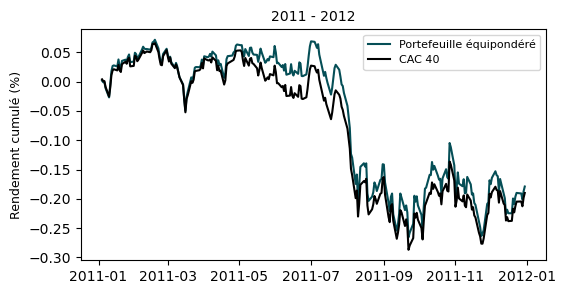

[*****                 11%%                      ]  2 of 19 completed

Performance du Portefeuille de 2011 à 2012 : -17.90%
Performance du Benchmark (CAC 40) de 2011 à 2012 : -19.00%

Sharpe Ratio du Portefeuille de 2011 à 2012 : -0.50
Sharpe Ratio du Benchmark (CAC 40) de 2011 à 2012 : -0.60



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


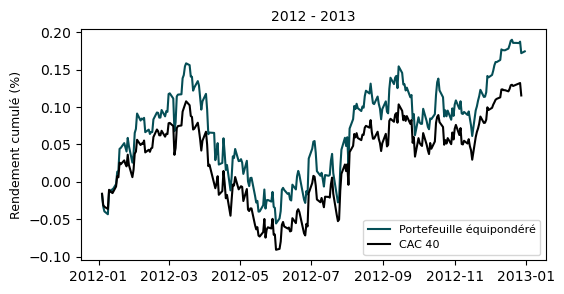

[************          26%%                      ]  5 of 19 completed

Performance du Portefeuille de 2012 à 2013 : 17.45%
Performance du Benchmark (CAC 40) de 2012 à 2013 : 11.55%

Sharpe Ratio du Portefeuille de 2012 à 2013 : 0.79
Sharpe Ratio du Benchmark (CAC 40) de 2012 à 2013 : 0.61



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


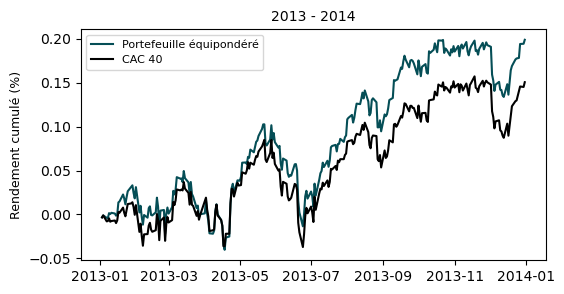

[**********************53%%                      ]  10 of 19 completed

Performance du Portefeuille de 2013 à 2014 : 19.88%
Performance du Benchmark (CAC 40) de 2013 à 2014 : 15.05%

Sharpe Ratio du Portefeuille de 2013 à 2014 : 1.18
Sharpe Ratio du Benchmark (CAC 40) de 2013 à 2014 : 0.92



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


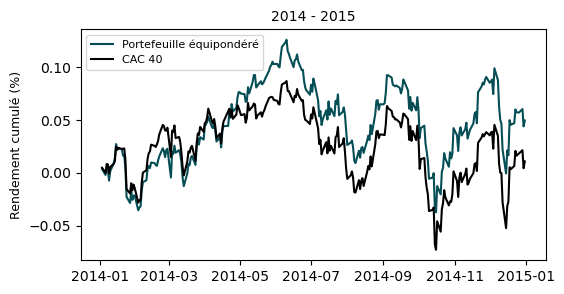

[*****                 11%%                      ]  2 of 19 completed

Performance du Portefeuille de 2014 à 2015 : 4.96%
Performance du Benchmark (CAC 40) de 2014 à 2015 : 1.08%

Sharpe Ratio du Portefeuille de 2014 à 2015 : 0.35
Sharpe Ratio du Benchmark (CAC 40) de 2014 à 2015 : 0.12



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


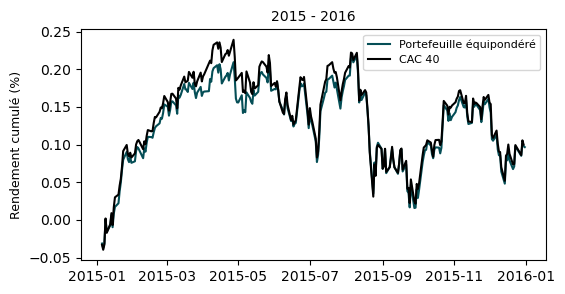

[**********            21%%                      ]  4 of 19 completed

Performance du Portefeuille de 2015 à 2016 : 9.66%
Performance du Benchmark (CAC 40) de 2015 à 2016 : 9.99%

Sharpe Ratio du Portefeuille de 2015 à 2016 : 0.51
Sharpe Ratio du Benchmark (CAC 40) de 2015 à 2016 : 0.51



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


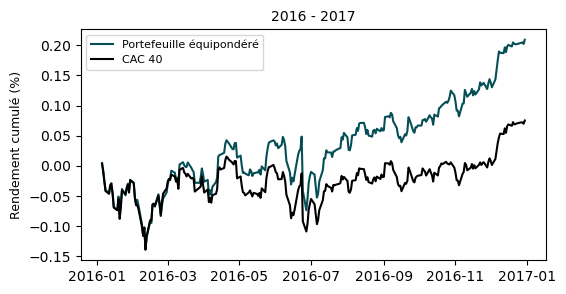

[**********            21%%                      ]  4 of 19 completed

Performance du Portefeuille de 2016 à 2017 : 20.89%
Performance du Benchmark (CAC 40) de 2016 à 2017 : 7.51%

Sharpe Ratio du Portefeuille de 2016 à 2017 : 0.96
Sharpe Ratio du Benchmark (CAC 40) de 2016 à 2017 : 0.43



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


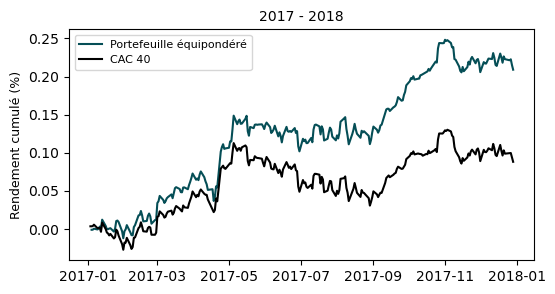

[********              16%%                      ]  3 of 19 completed

Performance du Portefeuille de 2017 à 2018 : 20.90%
Performance du Benchmark (CAC 40) de 2017 à 2018 : 8.81%

Sharpe Ratio du Portefeuille de 2017 à 2018 : 1.76
Sharpe Ratio du Benchmark (CAC 40) de 2017 à 2018 : 0.80



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


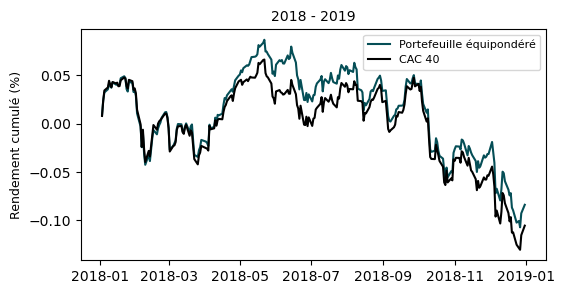

[************          26%%                      ]  5 of 19 completed

Performance du Portefeuille de 2018 à 2019 : -8.39%
Performance du Benchmark (CAC 40) de 2018 à 2019 : -10.55%

Sharpe Ratio du Portefeuille de 2018 à 2019 : -0.61
Sharpe Ratio du Benchmark (CAC 40) de 2018 à 2019 : -0.77



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


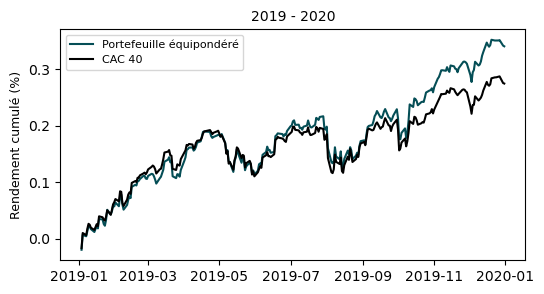

[*****                 11%%                      ]  2 of 19 completed

Performance du Portefeuille de 2019 à 2020 : 34.07%
Performance du Benchmark (CAC 40) de 2019 à 2020 : 27.48%

Sharpe Ratio du Portefeuille de 2019 à 2020 : 2.15
Sharpe Ratio du Benchmark (CAC 40) de 2019 à 2020 : 1.85



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


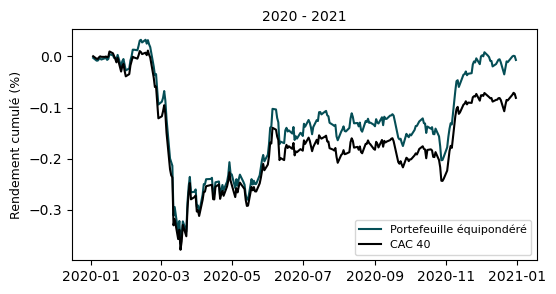

[**********            21%%                      ]  4 of 19 completed

Performance du Portefeuille de 2020 à 2021 : -0.69%
Performance du Benchmark (CAC 40) de 2020 à 2021 : -8.11%

Sharpe Ratio du Portefeuille de 2020 à 2021 : 0.13
Sharpe Ratio du Benchmark (CAC 40) de 2020 à 2021 : -0.11



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


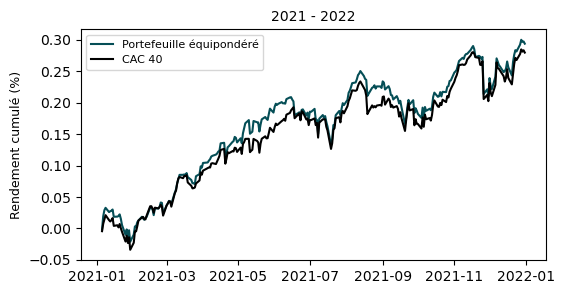

[*****                 11%%                      ]  2 of 19 completed

Performance du Portefeuille de 2021 à 2022 : 29.40%
Performance du Benchmark (CAC 40) de 2021 à 2022 : 27.98%

Sharpe Ratio du Portefeuille de 2021 à 2022 : 1.90
Sharpe Ratio du Benchmark (CAC 40) de 2021 à 2022 : 1.77



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


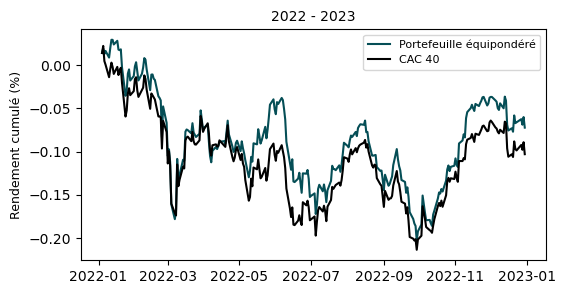

[************          26%%                      ]  5 of 19 completed

Performance du Portefeuille de 2022 à 2023 : -7.23%
Performance du Benchmark (CAC 40) de 2022 à 2023 : -10.30%

Sharpe Ratio du Portefeuille de 2022 à 2023 : -0.24
Sharpe Ratio du Benchmark (CAC 40) de 2022 à 2023 : -0.39



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


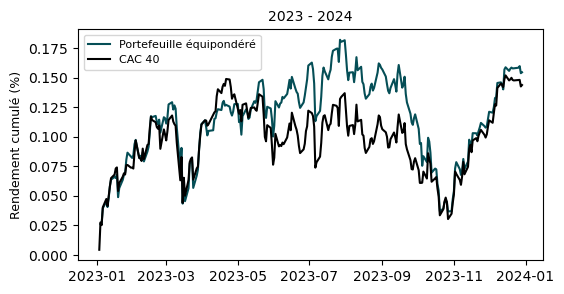

Performance du Portefeuille de 2023 à 2024 : 15.46%
Performance du Benchmark (CAC 40) de 2023 à 2024 : 14.38%

Sharpe Ratio du Portefeuille de 2023 à 2024 : 1.08
Sharpe Ratio du Benchmark (CAC 40) de 2023 à 2024 : 1.00



In [13]:
# Boucle pour visualiser les performances du portefeuille vs benchmark (CAC 40) pour chaque année
for start_year in range(2010, 2024):
    end_year = start_year + 1
    
    # Étape 1: Télécharger les données historiques pour le portefeuille et le CAC 40 pour une période d'un an
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-01-01"
    
    portfolio_data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Adj Close']
    benchmark_data = yf.download("^FCHI", start=start_date, end=end_date, interval="1d")['Adj Close']
    
    # Étape 2: Calculer les rendements journaliers pour chaque action du portefeuille
    portfolio_returns = portfolio_data.pct_change()
    
    # Étape 3: Calculer le rendement pondéré du portefeuille
    portfolio_weighted_return = portfolio_returns.dot(weights)
    
    # Étape 4: Calculer les rendements journaliers du benchmark (CAC 40)
    benchmark_returns = benchmark_data.pct_change()
    
    # Étape 5: Calculer les rendements cumulés pour le portefeuille et le benchmark
    portfolio_cumulative_return = (1 + portfolio_weighted_return).cumprod() - 1
    benchmark_cumulative_return = (1 + benchmark_returns).cumprod() - 1
    
    # Étape 6: Tracer les rendements cumulés pour comparaison
    plt.figure(figsize=(6, 3))
    plt.plot(portfolio_cumulative_return, label="Portefeuille équipondéré", color="#054E56")
    plt.plot(benchmark_cumulative_return, label="CAC 40", color="black")
    plt.title(f"{start_year} - {end_year}", fontsize=10)
    plt.xlabel("", fontsize=6)
    plt.ylabel("Rendement cumulé (%)", fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(False)
    plt.show()
    
    # Étape 7: Calculer et afficher la performance finale en pourcentage pour le portefeuille et le benchmark
    portfolio_performance_percent = portfolio_cumulative_return.iloc[-1] * 100
    benchmark_performance_percent = benchmark_cumulative_return.iloc[-1] * 100
    print(f"Performance du Portefeuille de {start_year} à {end_year} : {portfolio_performance_percent:.2f}%")
    print(f"Performance du Benchmark (CAC 40) de {start_year} à {end_year} : {benchmark_performance_percent:.2f}%\n")

    # Étape 8: Calculer la volatilité annuelle du portefeuille
    portfolio_volatility = portfolio_weighted_return.std() * np.sqrt(252)
    
    # Étape 9: Calculer la volatilité annuelle du benchmark
    benchmark_volatility = benchmark_returns.std() * np.sqrt(252)

    # Étape 10: Calculer le rendement annuel moyen du portefeuille
    portfolio_annual_return = portfolio_weighted_return.mean() * 252

    # Étape 11: Calculer le rendement annuel moyen du benchmark
    benchmark_annual_return = benchmark_returns.mean() * 252

    # Étape 12: Calculer le Ratio de Sharpe pour le portefeuille
    excess_portfolio_returns = portfolio_weighted_return - risk_free_rate
    sharpe_ratio_portfolio = (excess_portfolio_returns.mean() * 252) / portfolio_volatility

    # Étape 13: Calculer le Ratio de Sharpe pour le Benchmark (CAC 40)
    excess_benchmark_returns = benchmark_returns - risk_free_rate
    sharpe_ratio_benchmark = (excess_benchmark_returns.mean() * 252) / benchmark_volatility

    # Affichage des résultats
    print(f"Sharpe Ratio du Portefeuille de {start_year} à {end_year} : {sharpe_ratio_portfolio:.2f}")
    print(f"Sharpe Ratio du Benchmark (CAC 40) de {start_year} à {end_year} : {sharpe_ratio_benchmark:.2f}\n")

In [14]:
# Boucle permettant de visualiser les perfs du portefeuille vs benchmark sur 1 ans (base : janv-XX - janv XX+1)
for start_year in range(2010, 2024):
    end_year = start_year + 1
 
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-01-01"
    
    portfolio_data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Adj Close']
    benchmark_data = yf.download("^FCHI", start=start_date, end=end_date, interval="1d")['Adj Close']
    
    portfolio_returns = portfolio_data.pct_change()
    portfolio_weighted_return = portfolio_returns.dot(weights)
    benchmark_returns = benchmark_data.pct_change()
    portfolio_cumulative_return = (1 + portfolio_weighted_return).cumprod() - 1
    benchmark_cumulative_return = (1 + benchmark_returns).cumprod() - 1
    portfolio_performance_percent = portfolio_cumulative_return.iloc[-1] * 100
    benchmark_performance_percent = benchmark_cumulative_return.iloc[-1] * 100
    print(f"Performance du Portefeuille équipondéré {start_year} à {end_year} : {portfolio_performance_percent:.2f}%")
    print(f"Performance du Benchmark (CAC 40) de {start_year} à {end_year} : {benchmark_performance_percent:.2f}%\n")

[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[************          26%%                      ]  5 of 19 completed

Performance du Portefeuille équipondéré 2010 à 2011 : 5.60%
Performance du Benchmark (CAC 40) de 2010 à 2011 : -4.07%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[************          26%%                      ]  5 of 19 completed

Performance du Portefeuille équipondéré 2011 à 2012 : -17.90%
Performance du Benchmark (CAC 40) de 2011 à 2012 : -19.00%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[**********            21%%                      ]  4 of 19 completed

Performance du Portefeuille équipondéré 2012 à 2013 : 17.45%
Performance du Benchmark (CAC 40) de 2012 à 2013 : 11.55%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[************          26%%                      ]  5 of 19 completed

Performance du Portefeuille équipondéré 2013 à 2014 : 19.88%
Performance du Benchmark (CAC 40) de 2013 à 2014 : 15.05%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[********              16%%                      ]  3 of 19 completed

Performance du Portefeuille équipondéré 2014 à 2015 : 4.96%
Performance du Benchmark (CAC 40) de 2014 à 2015 : 1.08%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[***************       32%%                      ]  6 of 19 completed

Performance du Portefeuille équipondéré 2015 à 2016 : 9.66%
Performance du Benchmark (CAC 40) de 2015 à 2016 : 9.99%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[********              16%%                      ]  3 of 19 completed

Performance du Portefeuille équipondéré 2016 à 2017 : 20.89%
Performance du Benchmark (CAC 40) de 2016 à 2017 : 7.51%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[**********            21%%                      ]  4 of 19 completed

Performance du Portefeuille équipondéré 2017 à 2018 : 20.90%
Performance du Benchmark (CAC 40) de 2017 à 2018 : 8.81%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[********              16%%                      ]  3 of 19 completed

Performance du Portefeuille équipondéré 2018 à 2019 : -8.39%
Performance du Benchmark (CAC 40) de 2018 à 2019 : -10.55%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[******************    37%%                      ]  7 of 19 completed

Performance du Portefeuille équipondéré 2019 à 2020 : 34.07%
Performance du Benchmark (CAC 40) de 2019 à 2020 : 27.48%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[***************       32%%                      ]  6 of 19 completed

Performance du Portefeuille équipondéré 2020 à 2021 : -0.69%
Performance du Benchmark (CAC 40) de 2020 à 2021 : -8.11%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

Performance du Portefeuille équipondéré 2021 à 2022 : 29.40%
Performance du Benchmark (CAC 40) de 2021 à 2022 : 27.98%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed
[*****                 11%%                      ]  2 of 19 completed

Performance du Portefeuille équipondéré 2022 à 2023 : -7.23%
Performance du Benchmark (CAC 40) de 2022 à 2023 : -10.30%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed

Performance du Portefeuille équipondéré 2023 à 2024 : 15.46%
Performance du Benchmark (CAC 40) de 2023 à 2024 : 14.38%



[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


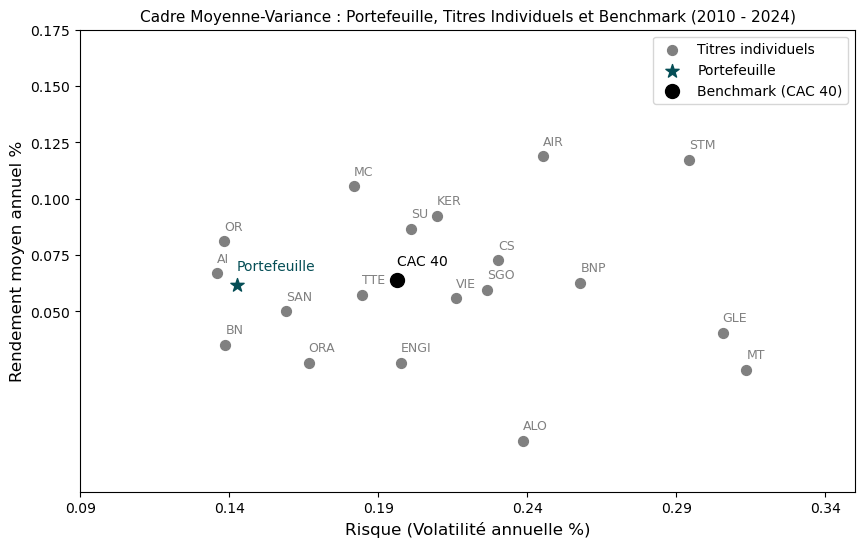

In [15]:
# Liste des tickers de votre portefeuille en janvier 2011

tickers_short = [ticker.replace(".PA", "").replace(".AS", "") for ticker in tickers]
data = yf.download(tickers, start="2010-01-01", end="2024-01-01", interval="1wk")['Adj Close']

benchmark_data = yf.download("^FCHI", start="2010-01-01", end="2024-01-01", interval="1wk")['Adj Close']
weekly_returns = data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()
weights = np.array([1/len(tickers)] * len(tickers))

# Calcul du rendement pondéré du portefeuille (rendement hebdomadaire moyen pondéré)
portfolio_returns = weekly_returns.dot(weights)

# Calcul des rendements annuels et volatilités
def annualize_returns(returns):
    return returns.mean() * 52  # Moyenne hebdomadaire annualisée

def annualize_volatility(returns):
    return returns.std() * np.sqrt(52)  # Volatilité hebdomadaire annualisée

# Calcul des rendements et des risques pour chaque titre du portefeuille
tickers_mean_returns = []
tickers_volatility = []

for ticker in tickers:
    ticker_returns = weekly_returns[ticker]
    mean_return = annualize_returns(ticker_returns)
    volatility = annualize_volatility(ticker_returns)
    tickers_mean_returns.append(mean_return)
    tickers_volatility.append(volatility)

# Calcul du rendement et du risque pour le portefeuille global
portfolio_mean_return = annualize_returns(portfolio_returns)
portfolio_volatility = annualize_volatility(portfolio_returns)
benchmark_mean_return = annualize_returns(benchmark_returns)
benchmark_volatility = annualize_volatility(benchmark_returns)

# Visualisation du cadre moyenne-variance
plt.figure(figsize=(10, 6))

# Titres individuels
plt.scatter(tickers_volatility, tickers_mean_returns, color='gray', s=50, label='Titres individuels')
for i, ticker in enumerate(tickers_short):
    plt.text(tickers_volatility[i], tickers_mean_returns[i] + 0.005, ticker, fontsize=9, color='gray')

# Portefeuille
plt.scatter(portfolio_volatility, portfolio_mean_return, color='#054E56', s=100, label='Portefeuille', marker='*')
plt.text(portfolio_volatility, portfolio_mean_return + 0.005, 'Portefeuille', fontsize=10, color='#054E56', verticalalignment='bottom')

# Benchmark (CAC 40)
plt.scatter(benchmark_volatility, benchmark_mean_return, color='black', s=100, label='Benchmark (CAC 40)')
plt.text(benchmark_volatility, benchmark_mean_return + 0.005, 'CAC 40', fontsize=10, color='black', verticalalignment='bottom')

# Limites ajustées des axes pour occuper tout le graphique
plt.xlim(0.09, 0.35)  # Etend la limite des risques (volatilité) pour mieux visualiser les points
plt.ylim(-0.03, 0.17)  # Etend la limite des rendements pour occuper tout l'espace
plt.xticks(np.arange(0.09, 0.35, 0.05))
plt.yticks(np.arange(0.05, 0.19, 0.025))

# Labels et légende
plt.title('Cadre Moyenne-Variance : Portefeuille, Titres Individuels et Benchmark (2010 - 2024)', fontsize=11)
plt.xlabel('Risque (Volatilité annuelle %)', fontsize=12)
plt.ylabel('Rendement moyen annuel %', fontsize=12)
plt.grid(False)
plt.legend()
plt.show()

[*********************100%%**********************]  19 of 19 completed
[*********************100%%**********************]  1 of 1 completed


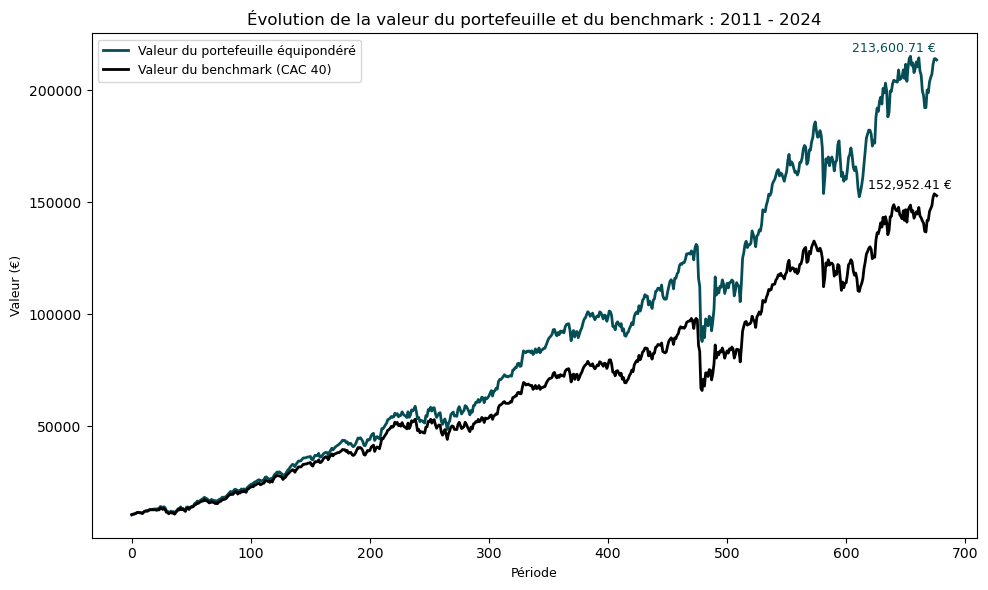

Valeur finale du portefeuille : 213,600.71 €
Valeur finale du benchmark (CAC 40) : 152,952.41 €


In [16]:
# Liste des tickers de votre portefeuille
tickers = ['TTE.PA', 'BN.PA', 'SAN.PA', 'BNP.PA', 'ENGI.PA', 'ORA.PA', 
           'MC.PA', 'CS.PA', 'OR.PA', 'GLE.PA', 'AI.PA', 'AIR.PA', 
           'ALO.PA', 'MT.AS', 'KER.PA', 'SGO.PA', 'SU.PA', 'STM', 'VIE.PA']

# Télécharger les données historiques hebdomadaires (2011 à aujourd'hui) pour le portefeuille
data = yf.download(tickers, start="2011-01-01", end="2024-01-01", interval="1wk")['Adj Close']

# Télécharger les données du CAC 40 comme benchmark
benchmark_data = yf.download("^FCHI", start="2011-01-01", end="2024-01-01", interval="1wk")['Adj Close']

# Calcul des rendements hebdomadaires pour chaque action du portefeuille et le CAC 40
weekly_returns = data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()

# Assurez-vous que les index de benchmark_returns et portfolio_returns sont alignés
aligned_returns = weekly_returns.index.intersection(benchmark_returns.index)
portfolio_returns = weekly_returns.loc[aligned_returns].dot(np.array([1/len(tickers)] * len(tickers)))
benchmark_returns = benchmark_returns.loc[aligned_returns]

# Paramètres d'investissement
initial_investment = 10000  # Montant initial en euros
weekly_contribution = 500 / 4  # Contribution hebdomadaire (500 € mensuels divisés par 4 semaines)

# Initialisation des variables pour suivre l'évolution de la valeur du portefeuille et du benchmark
portfolio_value = initial_investment
benchmark_value = initial_investment
portfolio_values = []
benchmark_values = []
time_periods = []

for i in range(len(portfolio_returns)):
    # Contribution hebdomadaire pour le portefeuille
    portfolio_value = (portfolio_value + weekly_contribution) * (1 + portfolio_returns.iloc[i])
    portfolio_values.append(portfolio_value)
    
    # Contribution hebdomadaire pour le benchmark (même principe que pour le portefeuille)
    benchmark_value = (benchmark_value + weekly_contribution) * (1 + benchmark_returns.iloc[i])
    benchmark_values.append(benchmark_value)
    
    time_periods.append(i)

# Visualisation de l'évolution de la valeur du portefeuille et du benchmark
plt.figure(figsize=(10, 6))
plt.plot(time_periods, portfolio_values, label='Valeur du portefeuille équipondéré', color='#054E56', linewidth=2)
plt.plot(time_periods, benchmark_values, label='Valeur du benchmark (CAC 40)', color='black', linewidth=2)
plt.title("Évolution de la valeur du portefeuille et du benchmark : 2011 - 2024", fontsize=12)
plt.xlabel("Période", fontsize=9)
plt.ylabel("Valeur (€)", fontsize=9)
plt.grid(False)
plt.legend(fontsize=9)

# Ajout des annotations des valeurs finales
final_portfolio_value = portfolio_values[-1]
plt.text(time_periods[-1] - 1, portfolio_values[-1]* 1.01, f'{final_portfolio_value:,.2f} €', 
         color='#054E56', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

final_benchmark_value = benchmark_values[-1]
# Décalage à droite du texte du benchmark
plt.text(time_periods[-1] + 13, benchmark_values[-1]* 1.01, f'{final_benchmark_value:,.2f} €', 
         color='black', fontsize=9, verticalalignment='bottom', horizontalalignment='right')  # Ajustement ici

plt.tight_layout()
plt.show()

# Affichage des valeurs finales
print(f"Valeur finale du portefeuille : {final_portfolio_value:,.2f} €")
print(f"Valeur finale du benchmark (CAC 40) : {final_benchmark_value:,.2f} €")